# Zebrafish pigmentation

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as it is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

In [ ]:
# get the latest pypi version  
# to get the latest version on github and other installations approaches, see:
# https://dynamo-release.readthedocs.io/en/latest/ten_minutes_to_dynamo.html#how-to-install
!pip install dynamo-release --upgrade --quiet

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 

this is like R's sessionInfo() which helps you to debug version related bugs if any. 

In [3]:
dyn.get_all_dependencies_version()

package dynamo-release pre-commit cvxopt      trimap numdifftools colorcet  \
version          1.0.0     2.11.1  1.2.6  1.4.3.dev1       0.9.39    2.0.6   

package python-igraph pynndescent hdbscan loompy matplotlib networkx   numba  \
version         0.9.0       0.5.2  0.8.27  3.0.6      3.4.3    2.5.1  0.53.1   

package   numpy pandas scikit-learn  scipy seaborn setuptools statsmodels  \
version  1.19.5  1.3.3       0.23.2  1.7.0  0.11.1     54.2.0      0.12.2   

package    tqdm umap-learn  
version  4.58.0      0.5.1

emulate ggplot2 plotting style with white background


In [4]:
dyn.configuration.set_figure_params('dynamo', background='white')


## Load data 

Dynamo comes with a few builtin sample datasets so you can familiarize with dynamo before analyzing your own dataset.
You can read your own data via `read`, `read_loom`, `read_h5ad`, `read_h5` (powered by the [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) package) or load_NASC_seq, etc. Here I just load the zebrafish sample data that comes with dynamo. This dataset has 4181 cells and 16940 genes. Its `.obs` attribute also included `condition`, `batch` information from the original study (you should also store those information to your `.obs` attribute which is essentially a Pandas Dataframe, see more at [anndata](https://anndata.readthedocs.io/en/latest/)). `Cluster`, `Cell_type`, umap coordinates that was originally analyzed with [Monocle 3](https://cole-trapnell-lab.github.io/monocle3/) are also provided. 

In [5]:
adata = dyn.sample_data.zebrafish()


|-----> Downloading data to ./data/zebrafish.h5ad


After loading data, you are ready to performs some preprocessing. You can run the `recipe_monocle` function that uses similar but generalized strategy from [Monocle 3](https://cole-trapnell-lab.github.io/monocle3/) to normalize all datasets in different layers (the spliced and unspliced or new, i.e. metabolic labelled, and total mRNAs or others), followed by feature selection, `log1p` transformation of the data and PCA dimension reduction. `recipe_monocle` also does a few additionl steps, which include: 

* converting ensemble gene names to gene official name and set them as `.var_names` if needed. 

* calculating number of expressed genes (`nGenes`), total expression values (`nCounts`), percentage of total mitochondria gene values (`pMito`) for each cell and save them to `.obs`. 

* detecting your experiment type (conventional scRNA-seq or time-resolved metabolic labeling datasets) and set certain proper layers (i.e. ignore some unconventional layers provided by the users) to be size factor normalized, `log1p` transformed, etc. 

* makings cell (`.obs_names`) and gene names (`.var_names`) unique. 

* savings data in `.layers` as `csr` sparse matrix for the purpose of memory efficency.

* adding collapsed `new, total` and `unspliced, spliced` layers from the `uu, ul, su, sl` layers of a metabolic labeling experiment. 

* calculating each cell's cell cycle stage score. 

* calculating new to total ratio (`ntr`) for each gene and cell.


Note that by default, we don't filter any cells or genes for your adata object to avoid the trouble of losing your favorite genes/cells. However, if your dataset is huge, we recommend filtering them by setting `keep_filtered_cells=False, keep_filtered_genes=False` in `recipe_monocle`. 

In [6]:
dyn.pp.recipe_monocle(adata) 

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

## RNA velocity with parallelism
RNA velocity ($\frac{ds}{dt}$) for conventional scRNA-seq is just $\frac{ds}{dt} = \beta u - \gamma s$ (while $u/s$ is the unspliced or spliced mRNA respectively.$\beta$ is splicing rate and is generally assumed to be 1 while $\gamma$ is degration rate and is what we need to estimate).  To estimate gamma for conventional scRNA-seq data, we provided three approaches `deterministic`, `stochastic` and `negbin`. The first one is equivalent to [velocyto](http://velocyto.org/)'s implementation or [scvelo](https://scvelo.readthedocs.io/)'s deterministic mode while the second one scvelo's  stochastic mode. Negative binomal is a novel method from us that relies on the negative binomial formulation of gene exrpession distribution at steady state. Furthermore, we support *multi-core* parallelism of gamma estimation so you can analyze your large single-cell datasets with dynamo efficiently. 

`dyn.tl.dynamics` function combines gamma estimation and velocity calculation in one-shot. Furthermore, it implicitly calls `dyn.tl.moments` first, and then performs the following steps:

* checks the data you have and determines the experimental type automatically, either the conventional scRNA-seq, kinetics, degradation or one-shot single-cell metabolic labelling experiment or the CITE-seq or REAP-seq co-assay, etc.

* learns the velocity for each feature gene using either the original deterministic model based on a steady-state assumption from the seminal RNA velocity work or a few new methods, including the stochastic (default) or negative binomial method for conventional scRNA-seq or kinetic, degradation or one-shot models for metabolic labeling based scRNA-seq.

Those later methods are based on moment equations which basically considers both mean and uncentered variance of gene expression. The moment based models require calculation of the first and second moments of the expression data, which relies on the cell nearest neighbours graph, constructed in the reduced PCA space from the spliced or total mRNA expression.

In [7]:
dyn.tl.dynamics(adata, model='stochastic', cores=3) 
# or dyn.tl.dynamics(adata, model='deterministic')
# or dyn.tl.dynamics(adata, model='stochastic', est_method='negbin')


|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [35.3489s]


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics'
    obsm: 'X_pca', 'X', 'cell_cycle_scores'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con'

Next we perform dimension reduction (by default, UMAP) and visualize the UMAP embedding of cells. The provided `Cell_type` information is also used to color cells. To get cluster/cell type information for your own data, dynamo also provides facilities to perform clustering and marker gene detection. By default we use HDBSCAN for [clustering](https://dynamo-release.readthedocs.io/en/latest/_autosummary/dynamo.tl.hdbscan.html#dynamo.tl.hdbscan). HDBSCAN package was developed also by Leland McInnes, the developer of **UMAP**. You may clustering your single cells in UMAP space (set `basis='umap'` instead of the default `pca` in HDBSCAN). See more discussion aboout this [here](https://umap-learn.readthedocs.io/en/latest/clustering.html).

For marker gene detection, please check functions in **Markers and differential expressions** section in our [API](https://dynamo-release.readthedocs.io/en/latest/API.html). A more detailed tutorial designated for this will be released soon. 

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [27.9326s]


<Figure size 600x400 with 0 Axes>

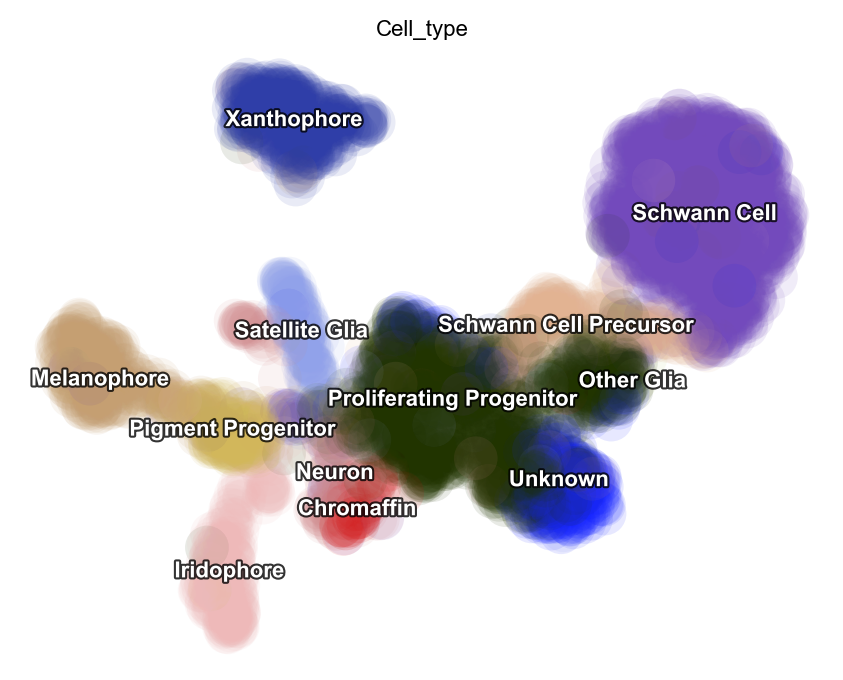

In [8]:
dyn.tl.reduceDimension(adata)

dyn.pl.umap(adata, color='Cell_type')

In [9]:
import umap



Kinetic estimation of the conventional scRNA-seq and metabolic labeling based scRNA-seq is often tricky and has a lot pitfalls. Sometimes you may even observed undesired backward vector flow. You can evaluate the confidence of gene-wise velocity via: 
```
dyn.tl.gene_wise_confidence(adata, group='group', lineage_dict={'Progenitor': ['terminal_cell_state']})
```

Here `group` is the column for the group informations for cells in the `.obs`. `lineage_dict` is a dictionary indicates broad lineage information in which key points to the progenitor group while values (a list) are the possible terminal cell groups, all from the `group` column.

In the following, let us have a look at the phase diagram of some genes that have velocity calculated. You will see the  `pvalb1` gene has a strange phase diagram with a few cells have high spliced expression values but extremely low unspliced expression values. Those kind of phase space may points to inproper intron capture of those genes during the library prepartion or sequencing and they should never be used for velocity projection and vector field analysis. A tutorial with details for identifying those genes, evaluating the confidence of velocity estimation and then correcting (briefly mentioned below) the RNA velocity results will be released soon.  

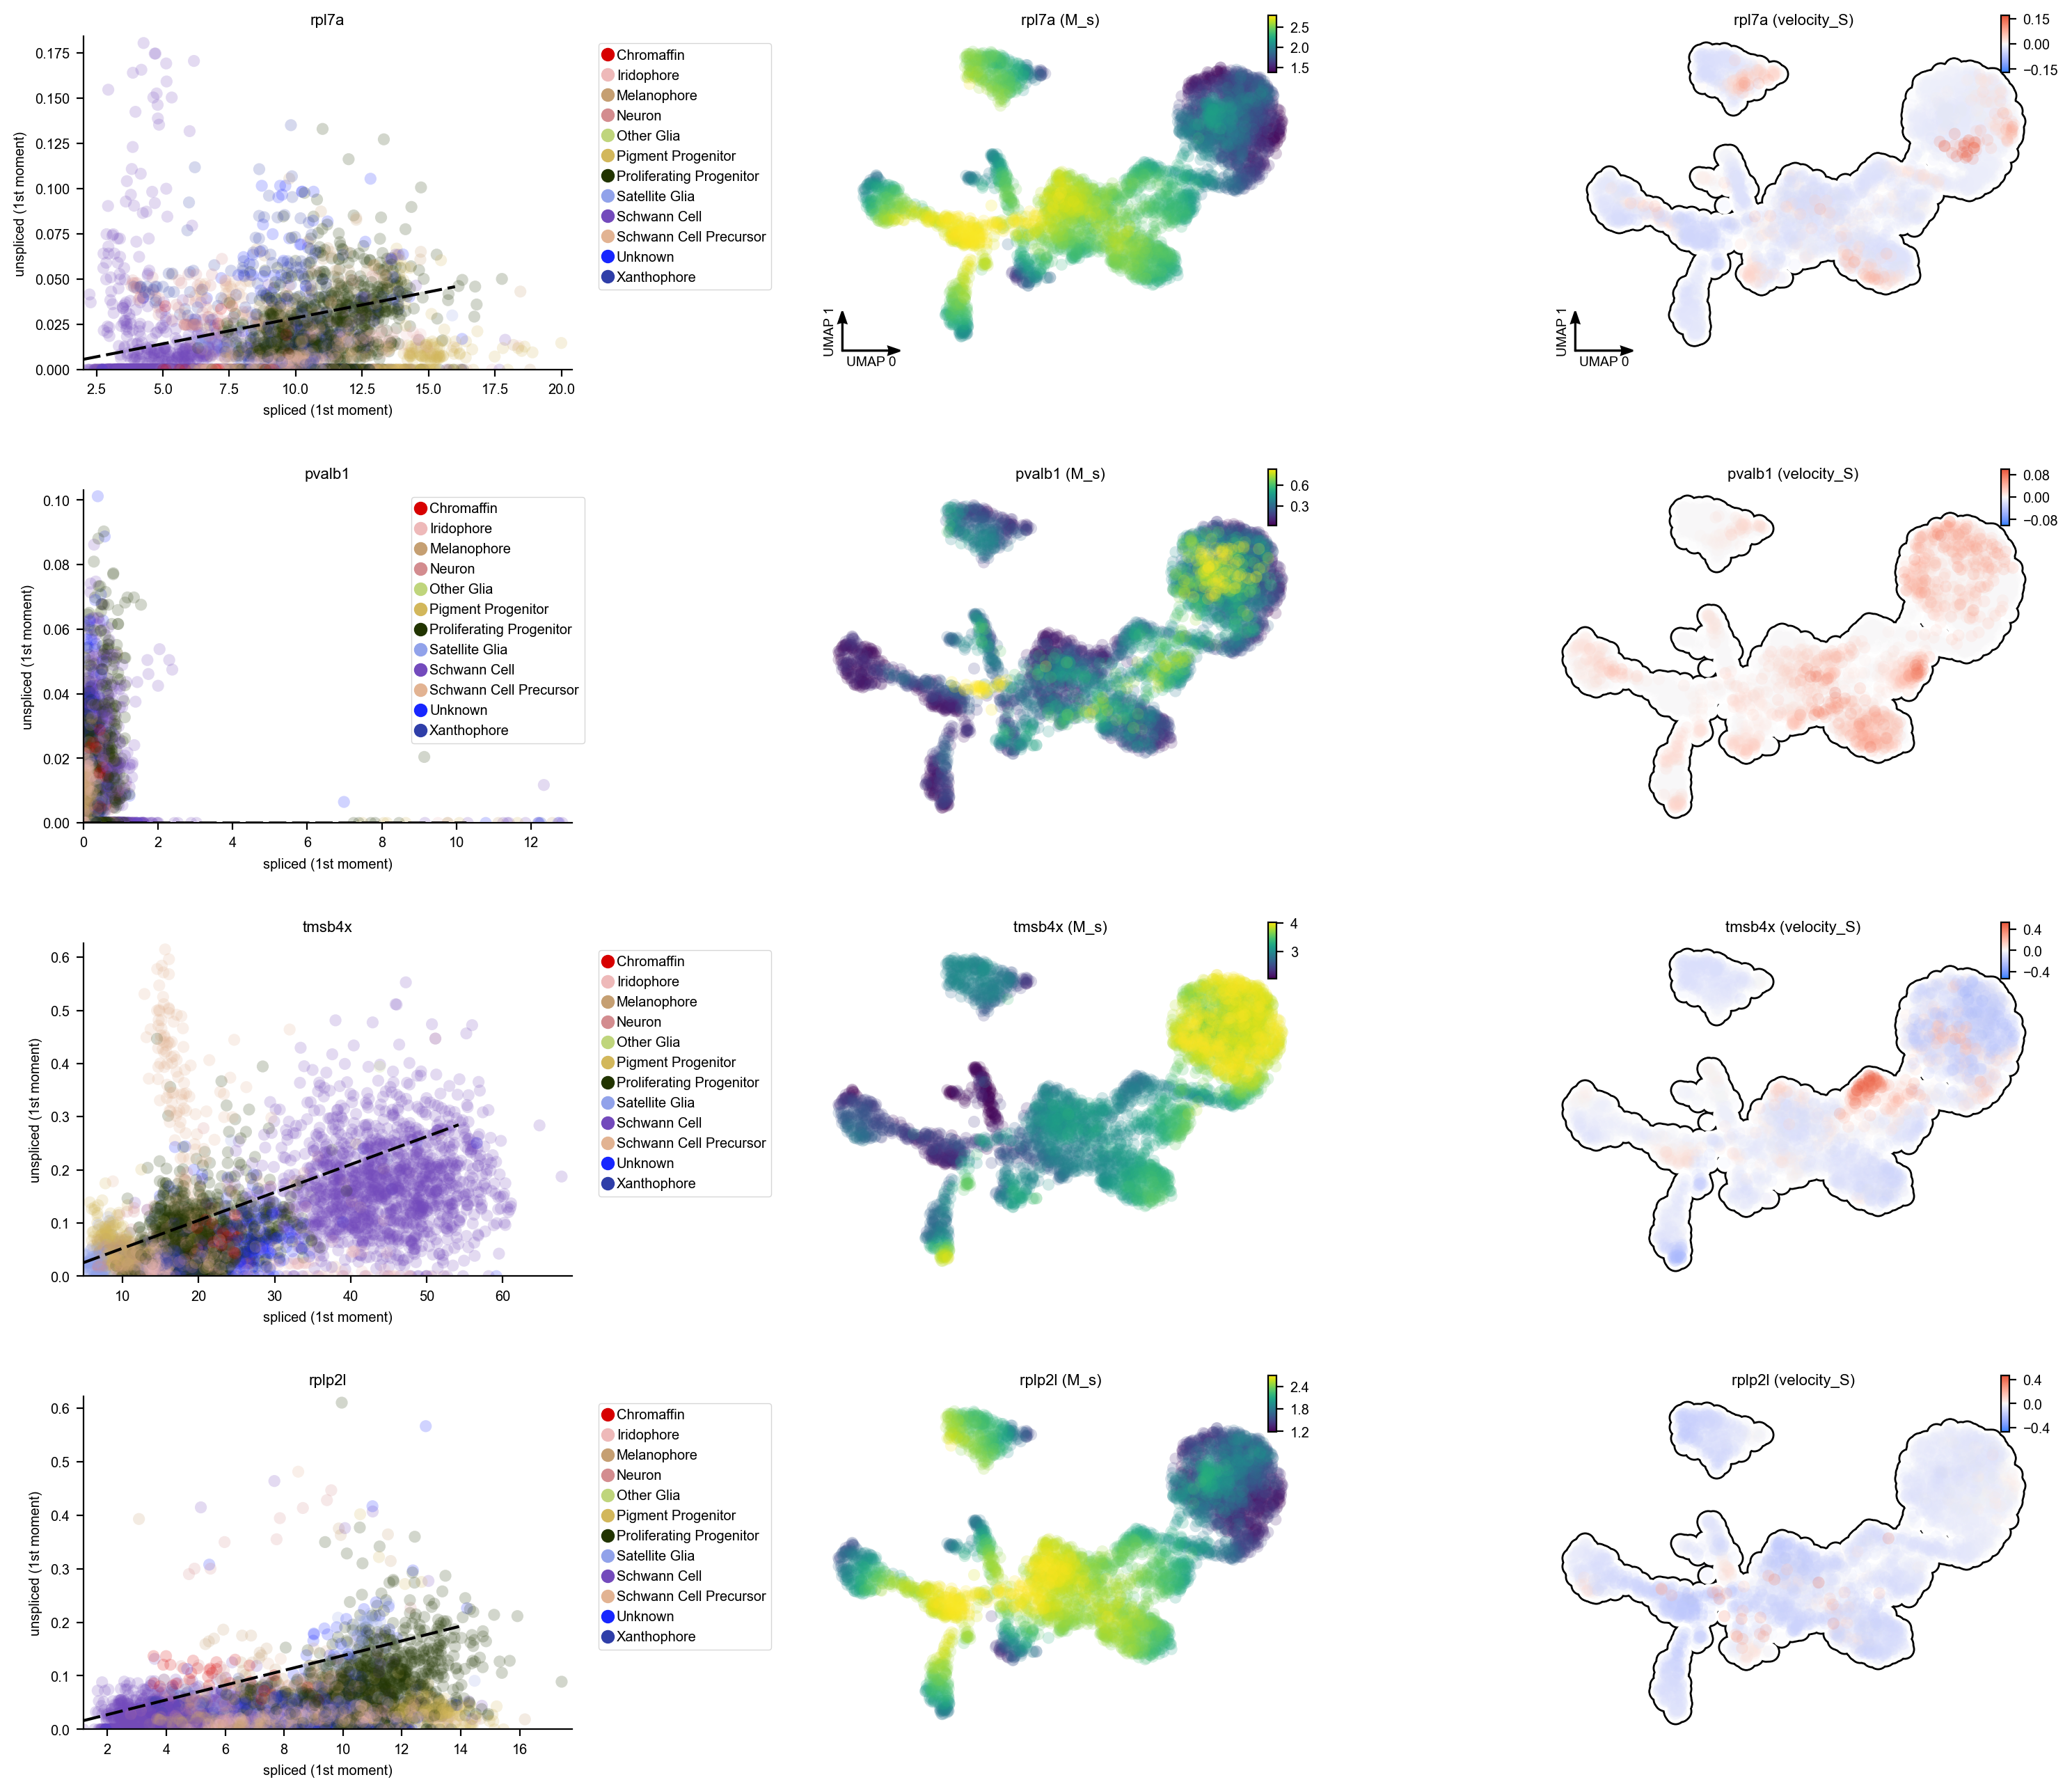

In [10]:
dyn.pl.phase_portraits(adata, genes=adata.var_names[adata.var.use_for_dynamics][:4], figsize=(6, 4), color='Cell_type')

##  Velocity projection 

In order to visualize the velocity vectors, we need to project the high dimensional velocity vector of cells to lower dimension (although dynamo also enables you to visualize raw gene-pair velocity vectors, see below). The projection involves calculating a transition matrix between cells for local averaging of velocity vectors in low dimension. There are three methods to calculate the transition matrix, either `kmc`, `cosine`, `pearson`. `kmc` is our new approach to learn the transition matrix via diffusion approximation or an Itô kernel. `cosine` or `pearson` are the methods used in the original [velocyto](http://velocyto.org/) or the [scvelo](https://scvelo.readthedocs.io/) implementation. Kernels that are based on the `reconstructed vector field` in high dimension is also possible and maybe more suitable because of its and robustness and smoothness. We will show you how to do that in another tutorial soon!

In [11]:
dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'})


|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [7.7590s]
|----->

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'Cell_type_colors', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'cell_cycle_scores', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'un

You can check the confidence of cell-wise velocity to understand how reliable the recovered velocity is across cells or even `correct` velocty based on some prior:
```
dyn.tl.cell_wise_confidence(adata, basis='pca')
dyn.tl.confident_cell_velocities(adata, group='group', lineage_dict={'Progenitor': ['terminal_cell_state']},)
```

There are three methods implemented for calculating the cell wise velocity confidence metric. By default it uses `jaccard` index, which measures how well each velocity vector meets the geometric constraints defined by the local neighborhood structure. Jaccard index is calculated as the fraction of the number of the intersected set of nearest neighbors from each cell at current expression state (X) and that from the future expression state (X + V) over the number of the union of these two sets. The `cosine` or `correlation` method is similar to that used by [scVelo](https://github.com/theislab/scvelo).

Next let us visualize the projected RNA velocity. We can see that the recovered RNA velocity flow shows a nice transition from `proliferating progenitors` to `pigment progenitors` which then bifurcate into either `melanophore` or `iridopore` on the left. In the middle, the `proliferating progenitors` bifurcate upward into either `chromaffin`, `neuron` or `satellite glia cells`. On the right, the `proliferation progenitors` bifurcate into either `Schwann cell precursor` which then become `Schwann cells` or `other glia`. In the bottom, some `proliferating progenitors `choose to become an `unkown` cell lineage. In addition, the `xanthophore` cells are seem to be an outlier group on the top, indicating it has a different lineage path comparing to `melanophore` or `iridophore` pigment cells. The transcriptional discontinuity from multipotent progenitors to `xanthophore` cells may also imply its lineage trajectory is more rapid comparing to that of `melanophore` or `iridophore` pigment cells. 


<Figure size 600x400 with 0 Axes>

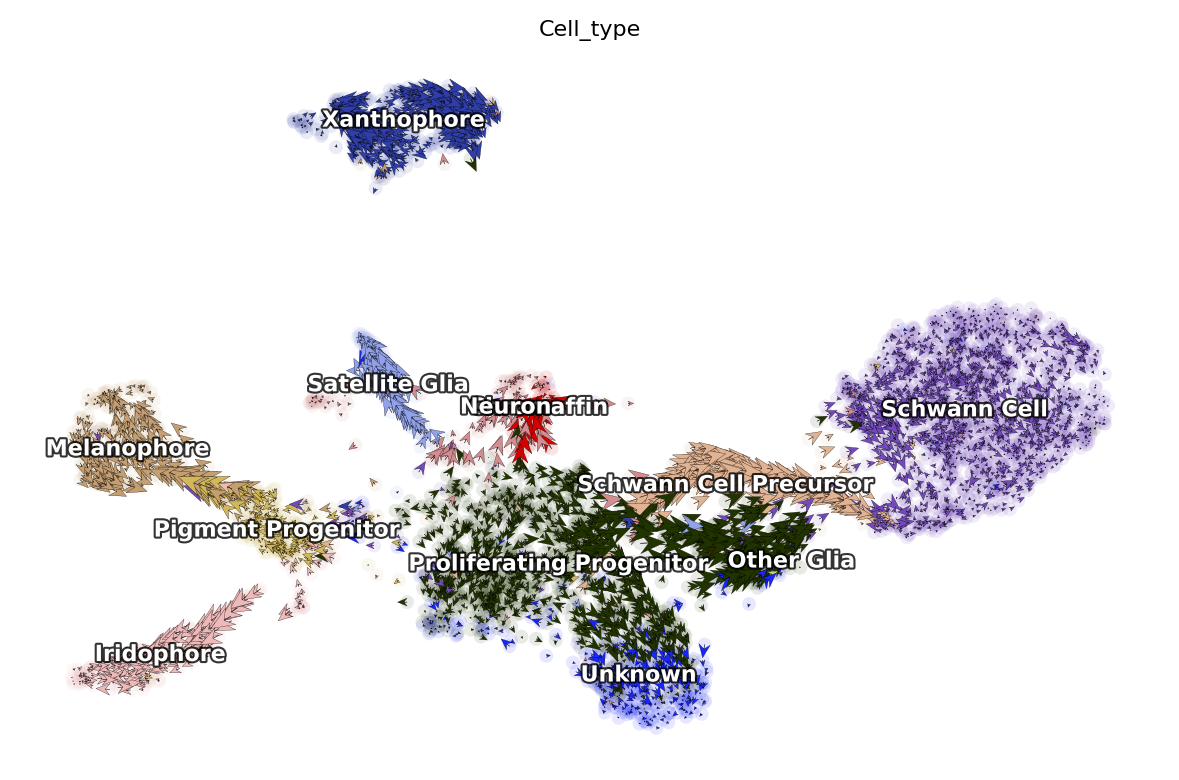

In [12]:
adata = dyn.read('./zebrafish_adata_processed.h5ad')
dyn.pl.cell_wise_vectors(adata, color=['Cell_type'], basis='umap', show_legend='on data', quiver_length=6, quiver_size=6, pointsize=0.1, show_arrowed_spines=False)


<Figure size 600x400 with 0 Axes>

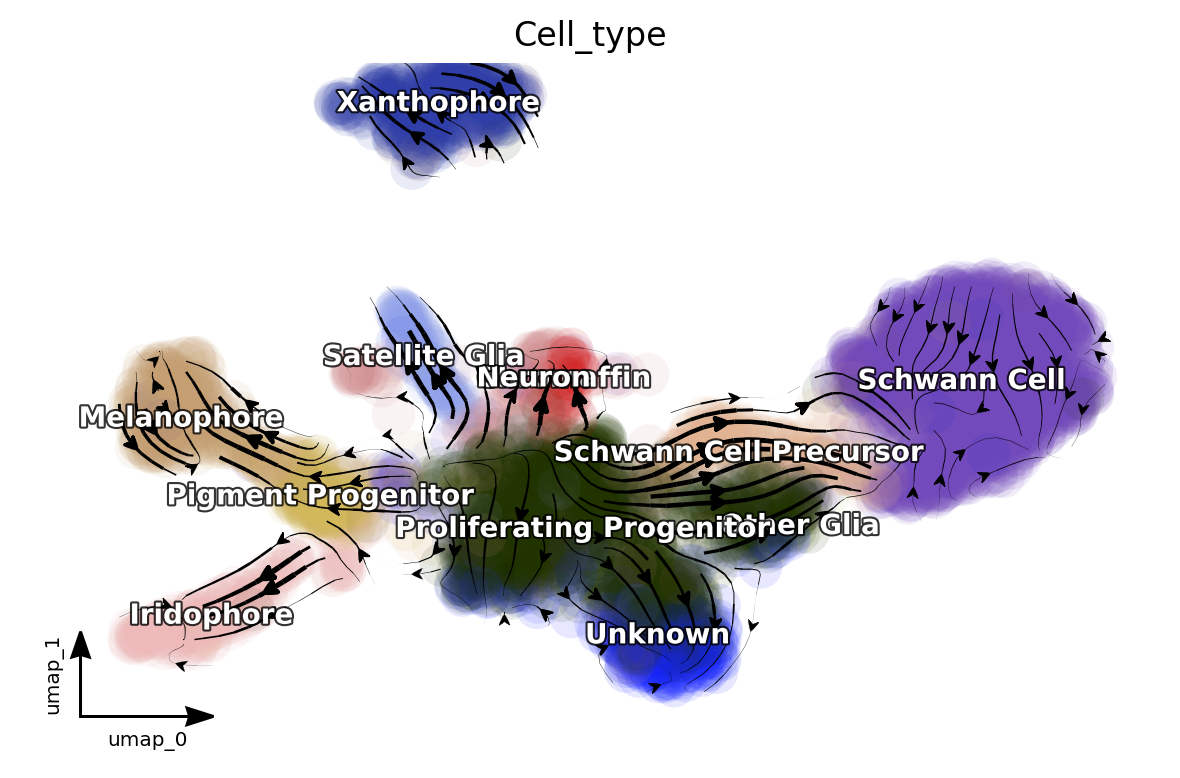

In [13]:
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True)


Note that, if you pass `x='gene_a', y='gene_b'` to `cell_wise_vectors`, `grid_vectors` or `streamline_plot`, you can visualize the raw gene-pair velocity flows. `gene_a` and `gene_b` need to have velocity calculated (or `use_for_dynamics` in `.var` for those genes are `True`)

## Reconstruct vector field

In classical physics, including fluidics and aerodynamics, velocity and acceleration vector fields are used as fundamental tools to describe motion or external force of objects, respectively. In analogy, RNA velocity or protein accelerations estimated from single cells can be regarded as sparse samples in the velocity (La Manno et al. 2018) or acceleration vector field (Gorin, Svensson, and Pachter 2019) that defined on the gene expression space. 

In general, a vector field can be defined as a vector-valued function f that maps any points (or cells’ expression state) x in a domain Ω with D dimension (or the gene expression system with D transcripts / proteins) to a vector y (for example, the velocity or acceleration for different genes or proteins), that is f(x) = y. 

To formally define the problem of velocity vector field learning, we consider a set of measured cells with pairs of current and estimated future expression states. The difference between the predicted future state and current state for each cell corresponds to the velocity. We suppose that the measured single-cell velocity is sampled from a smooth, differentiable vector field f that maps from xi to yi on the entire domain. Normally, single cell velocity measurements are results of biased, noisy and sparse sampling of the entire state space, thus the goal of velocity vector field reconstruction is to robustly learn a mapping function f that outputs yj given any point xj on the domain based on the observed data with certain smoothness constraints (Jiayi Ma et al. 2013). Under ideal scenario, the mapping function f should recover the true velocity vector field on the entire domain and predict the true dynamics in regions of expression space that are not sampled. To reconstruct vector field function in dynamo, you can simply use the following function to do all the heavy-lifting:

In [14]:
# you can set `verbose = 1/2/3` to obtain different levels of running information of vector field reconstruction
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True) 

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [9.7869s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> Computing curl...
Calculating 2-D curl: 100%|██████████| 4181/4181 [00:00<00:00, 8485.10it/s]
|-----> Computing divergence...
Calculating divergence: 100%|██████████| 5/5 [00:00<00:00, 13.69it/s]
|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <in

Vector field recunstruction is blazingly efficient and scale linearly with the cell number and dimensions. So you can do vector field reconstruction for hundred thousands of cells in PCA space on a matter of minutes. How good your vector field reconstruction is? We have several metrics to quantify that and we will provide a detailed tutorial on that in a couple of days. The easiest way, though, is to check the energy / energy change rate to see whether they are decreasing and gradually stabiling during the vector field learning process: 
```python
dyn.pl.plot_energy(adata) 
```

## Characterize vector field topology
Since we learn the vector field function of the data, we can then characterize the topology of the full vector field space. For example, we are able to identify

* the fixed points (attractor/saddles, etc.) which may corresponds to terminal cell types or progenitors;

* nullcline, separatrices of a recovered dynamic system, which may formally define the dynamical behaviour or the boundary of cell types in gene expression space.

Note that we use the name of `topography` instead of `topology` in `tools` or `plot` modules because we figured out the 2D full vector field plot (instead of just domains with cells as those visualized by `streamline_plot` function) with those fixed points, nullclines, etc. looks like a topography plot. Enlighten us if you have a better idea. And see also more discussion [here](https://www.askdifference.com/topology-vs-topography/).

When we recostruct a 2 D vector field (which is the case above), we automatically characterize the vector field topology. Let us take a look a the fixed points identified by dynamo for this system. 

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...


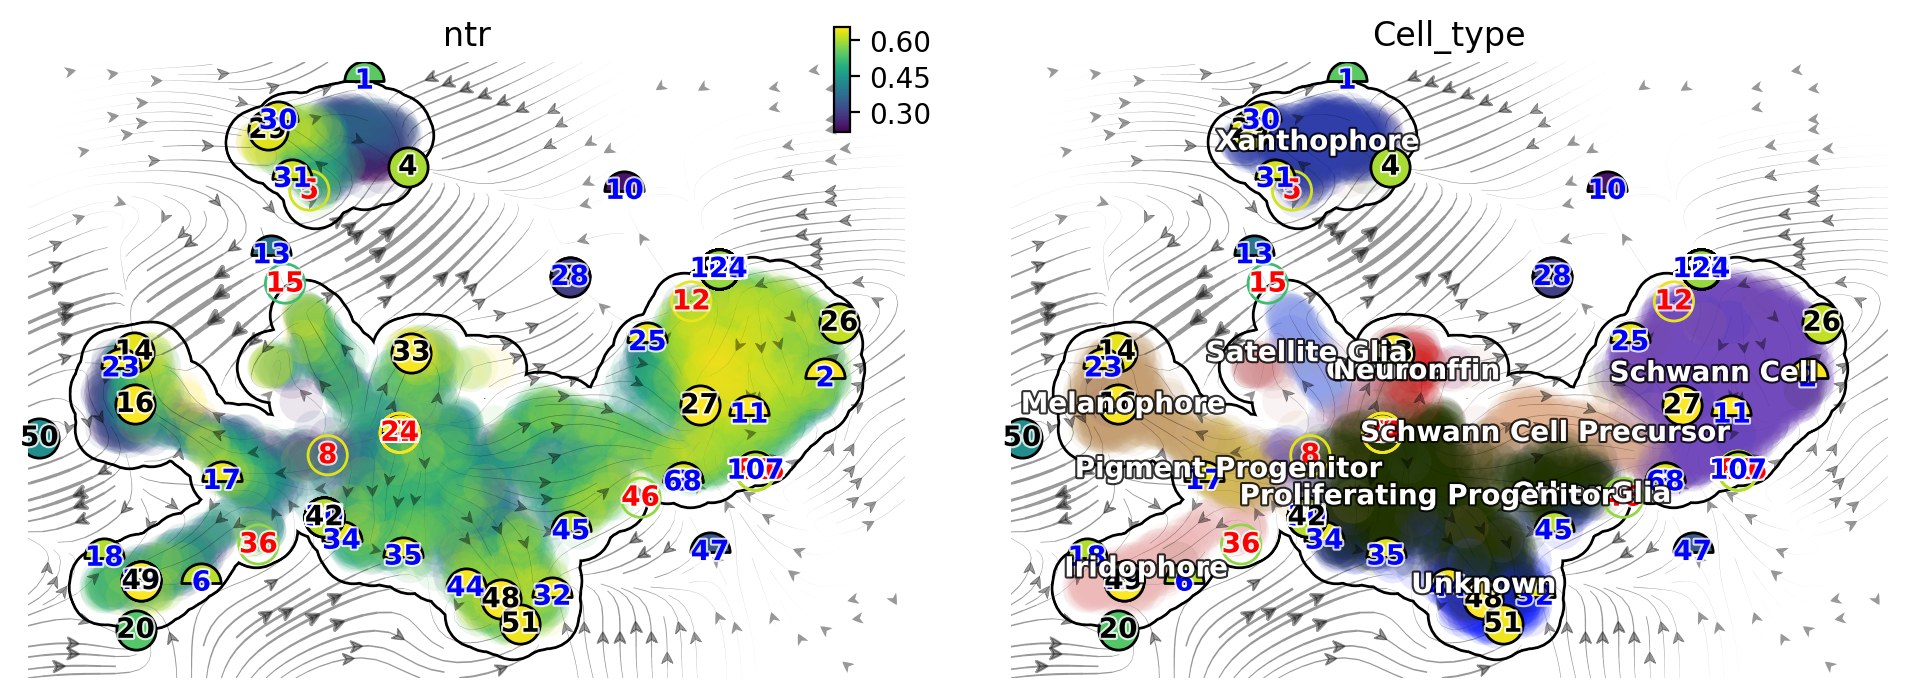

In [15]:
dyn.pl.topography(adata, basis='umap', background='white', color=['ntr', 'Cell_type'], streamline_color='black', show_legend='on data', frontier=True)


There are a lot of fixed points identified by dynamo. Some of them are less confident than others and we use the filled color of each node to represent the confidence. The shape of node also has some meaning. Half circles are saddle points while full circle are stable fixed points (the eigenvalue of the jacobian matrix at those places are all negative based on the reconstructed vector field). The color of digits in each node is related to the type of fixed points:
    
* $\color{black}{\text{black}}$: absorbing fixed points; 
* $\color{red}{\text{red}}$: emitting fixed points; 
* $\color{blue}{\text{blue}}$: unstable fixed points. 

We notice that, interesting, `node 6` corresponds an emitting fixed point which makes sense as it is located in the domain of progenitor cell state; on the other hand, `nodes 70, 44, 14 and 72` are absorbing fixed points, and each corresponds to the `melanophore`, `iridophore`, `unknown` or the `xanthophore` terminal cell type state. Lastly, `nodes 20 and 29` are unstable fixed points (saddle points), each corresponds to the bifurcation point of the iridophore and melanophore lineages or that of the neuron and satellite glia lineages. 

So overall this topology analysis did a pretty good job! 

The concept of potential landscape is widely appreciated across various biological disciplines, for example the adaptive landscape in population genetics, protein-folding funnel landscape in biochemistry, epigenetic landscape in developmental biology. In the context of cell fate transition, for example, differentiation, carcinogenesis, etc, a potential landscape not only offers an intuitive description of the global dynamics of the biological process but also provides key insights to understand the multi-stability and transition rate between different cell types as well as to quantify the optimal path of cell fate transition.

The classical definition of potential function in physics requires gradient systems (no curl/cycling part), it thus is often not applicable to open biological system. In dynamo we provided several ways to quantify the potential of single cells by decomposing the vector field into gradient, curl parts, etc and use the gradient part to define potential. The recommended method is built on the Hodge decomposition on simplicial complexes (a sparse directional graph) constructed based on the learned vector field function that provides fruitful analogy of gradient, curl and harmonic (cyclic) flows on manifold.

Single cell potential (In fact, it is the negative of potential here for the purpose to match up with the common usuage of `pseudotime` so that small values correspond to the progenitor state while large values terminal cell states.) estimated by dynamo can be regarded as a replacement of pseudotime. Since dynamo utilizes velocity which consists of direction and magnitude of cell dynamics, potential should be more relevant to real time and intrinsically directional (so you don’t need to orient the trajectory). 

<Figure size 600x400 with 0 Axes>

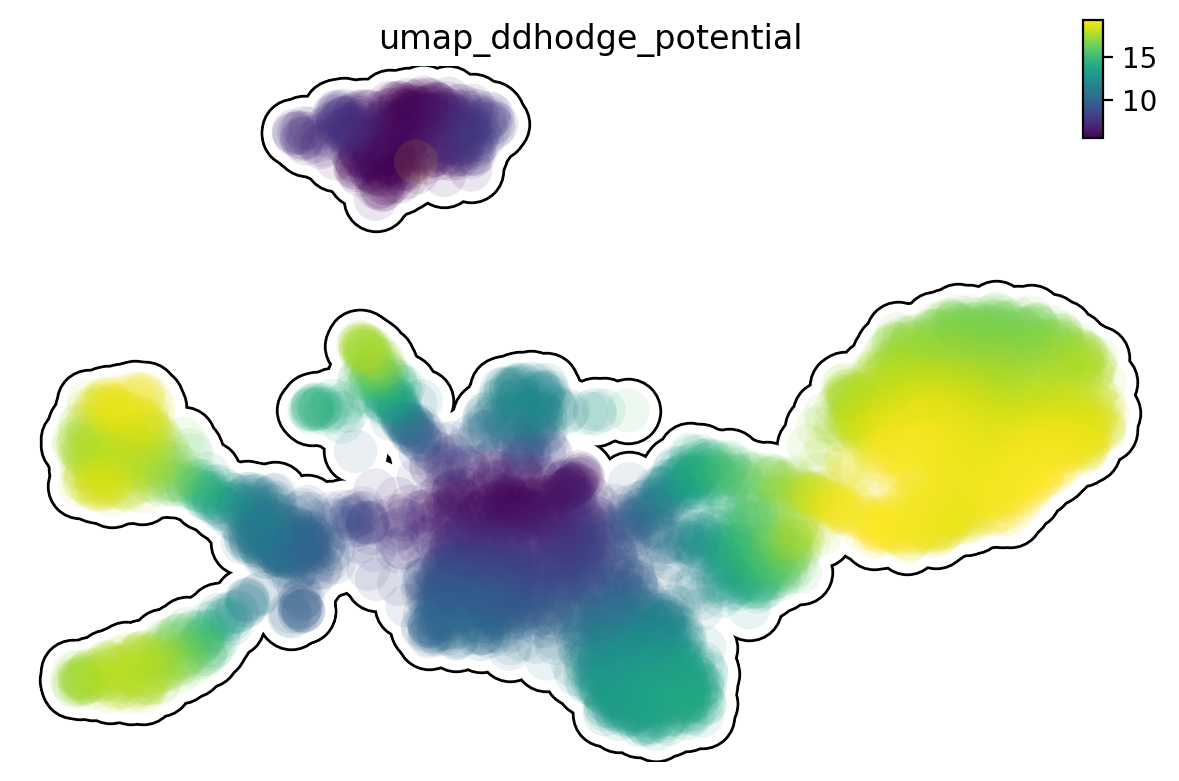

In [16]:
dyn.pl.umap(adata,  color='umap_ddhodge_potential', frontier=True)

Here we can check a few genes from `figure 3 (si 5)` of Saunders, et al (2019) to 
see their expression dynamics over time. As expected, we can see that `mitfa` expression declined only marginally with melanophore differentiation yet decreased markedly with a transition from progenitor to iridophore as expected (Curran et al., 2010). `pax3a` was expressed in pigment progenitors and decreased across pseudotime in melanophores, whereas expression of `tfec`, a transcription factor expressed in iridophores (Lister et al., 2011), increased over pseudotime. Melanin synthesis enzyme genes, `dct` and `tyrp1b`, as well as `pmel`, encoding a melanosome-associated transmembrane protein, all increased over pseudotime in melanophores. In iridophores, `gpnmb` and `pnp4a` showed elevated expression late in pseudotime, as expected (Curran et al., 2010; Higdon et al., 2013).

Exception: Make sure your `x` and `y` are integers, gene names, column names in .obs, etc.

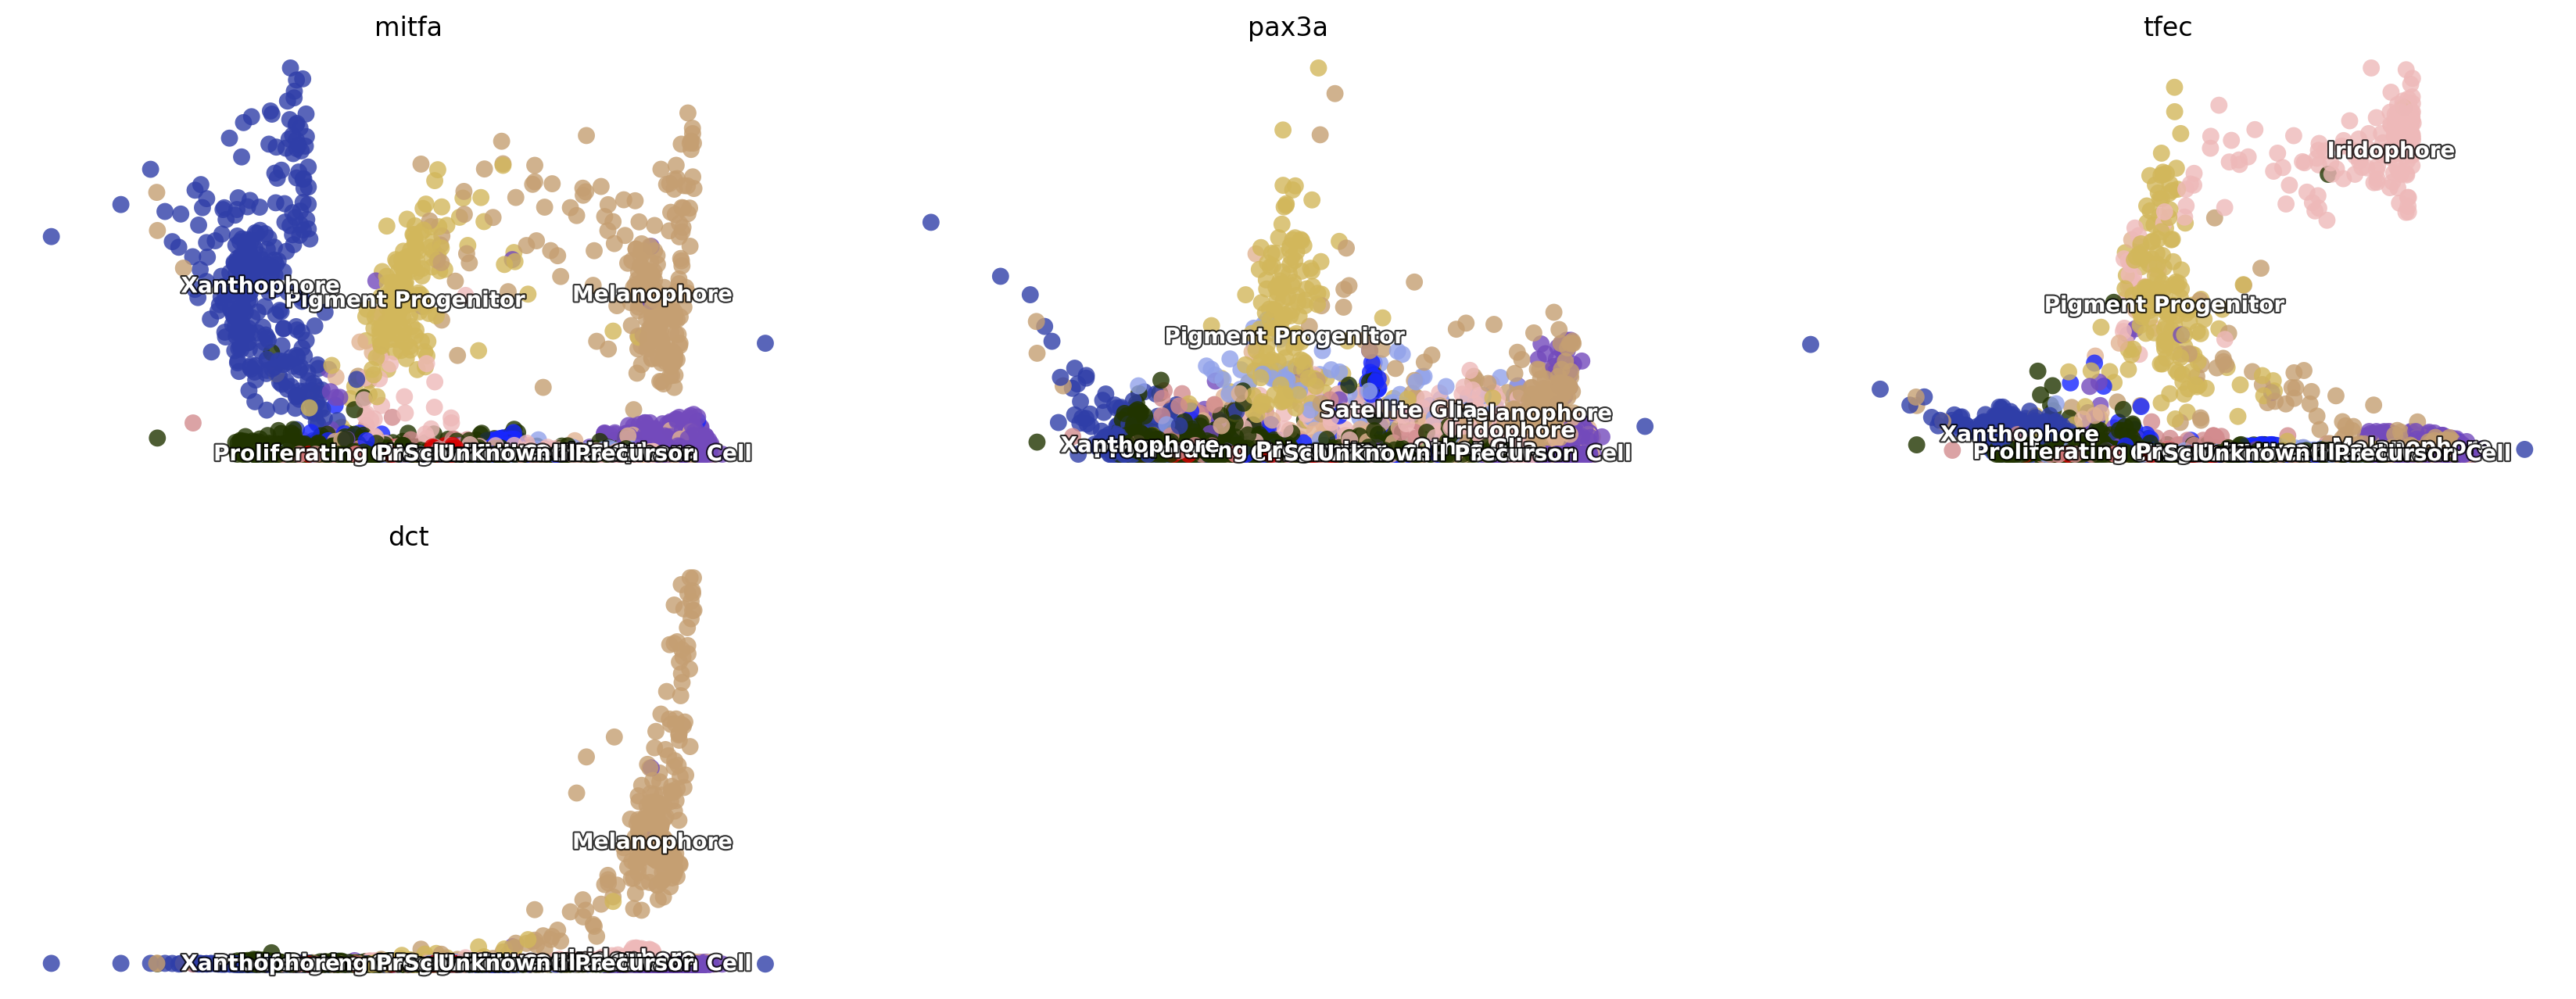

In [17]:
import numpy as np 

fig3_si5 = ['mitfa', 'pax3a', 'tfec', 'dct', 'alx4b', 'tyrp1b', 'gpnmb', 'pmela', 'pnp4a']

dyn.pl.scatters(adata, x=np.repeat('umap_ddhodge_potential', 9), pointsize=0.25, alpha=0.8, y=fig3_si5, layer='X_spliced', color='Cell_type',
                ncols=3, background='white', figsize=(7, 4))


## Beyond RNA velocity 

Here let us take a glimpse on how dynamo can go beyond RNA velocity analysis by taking advantage of the analytical vector field function it learns. Here we will first project the RNA velocity to pca space and then reconstruct the vector field function in the PCA space. We then followed by calculating `curl` (`curl` is calculated in 2 dimensional UMAP space by default as it is only defined in 2/3 dimension), `divergence`, `acceleration` and `curvature`. Those calculations are incredibly efficient (on the order of seconds for ten thousands of cells in 30 PCs) as they are calculated analytically based on the reconstructed vector field function. 

* **curl**: a quantity to characterize the infinitesimal rotation of a cell state based on the reconstructed vector field.
    * in 2D, curl is a value; in 3D curl, is a matrix.
    * if rotation is clockwise, 2D curl has negative value and vice versa
    * combinbing with expression of cell cycle markers, curl analysis can help us to reveal whether a cell is going through a strong cell cycle process.

* **divergence**: a quantity to characterize local "outgoingness" of  a cell – the extent to which there is more of the field vectors exiting an infinitesimal region of space than entering it. 
    * positive values means cells is going out to become other cells or cell’s movement to other cell is speeded up and vice versa.
    * divergence analysis can be used to reveal progenitor (source) or a terminal cell state (sink).

* **acceleration**: the derivative of velocity vector. 
    * if cell speeds up (normally happen when cells exit cell cycle and start to commit), the acceleration will be positive and vice versa.
    * RNA acceleration is a vector like RNA velocity vector so you can actually plot acceleration field like velocity field (that is why we name our vector flow related plotting functions `cell_wise_vectors`, `grid_vectors` to support plotting both `velocity` and `acceleration field` (see below)). 
    * Here the norm of the acceleration for all PC components in each cells will be calculated and visualized (like the **speed/magnitude** of the velocity vector). 

* **curvature**: a quantity to characterize the curviness a cell’s vector field trajectory.
    * if a progenitor develops into multiple lineages, some of those paths will have curvature (it is like making a turn on a crossroad while driving a car). 
    * genes strongly contribute to the curvature correspond to regulatory genes steering the cell fate


In [ ]:
dyn.tl.cell_velocities(adata, basis='pca')
dyn.vf.VectorField(adata, basis='pca')
dyn.vf.speed(adata, basis='pca')
dyn.vf.curl(adata, basis='umap')
dyn.vf.divergence(adata, basis='pca')
dyn.vf.acceleration(adata, basis='pca')
dyn.vf.curvature(adata, basis='pca')

## Integrative analysis 

We can integrate those above quantities to fully characterize the regulatory mechanism during zebrafish pigmentation. 

A separate tutorial is needed to fully explore these analyses, but let’s take a quick look at the results. We can see that:

* from cell speed and acceleration, progenitors generally have low speed as it is like a metastable cell state. However transition of pigment progenitors and proliferating progenitors speeds up after committing to a particular lineage, for example, iridophore/melanophore/shawnn cell lineage, etc. 

* from cell divergence, those progenitors (pigment progenitors and proliferating progenitors) functions like a source with high divergence while melanophore/iridophores/chromaffin/schawn cells as well as other cell types functions like a sink with significantly lower divergence. 

* from cell curvature, when cell makes cell fate decisions (at the bifurcation point of iridophore and melanophore lineages or that of the neuron and satellite glia lineages), strong curvature is apparent. Curvature is also artificially strong when velocity is noisy.


In [ ]:
import matplotlib.pyplot as plt

fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
f1_axes
f1_axes[0, 0] = dyn.pl.speed(adata, pointsize=0.5, alpha = 0.7, ax=f1_axes[0, 0], quiver_length=6, quiver_size=6, save_show_or_return='return')
f1_axes[0, 1] = dyn.pl.divergence(adata, ax=f1_axes[0, 1], quiver_length=12, quiver_size=12, save_show_or_return='return')
f1_axes[1, 0] = dyn.pl.acceleration(adata, ax=f1_axes[1, 0], save_show_or_return='return')
f1_axes[1, 1] = dyn.pl.curvature(adata, ax=f1_axes[1, 1], save_show_or_return='return')
plt.show()

Emulate ggplot2 plotting styple with black background, get ready for a cool presentation!!!

In [ ]:
dyn.configuration.set_figure_params('dynamo', background='black')  

In [ ]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
f1_axes
f1_axes[0, 0] = dyn.pl.speed(adata, pointsize=0.1, alpha = 0.7, ax=f1_axes[0, 0], quiver_length=6, quiver_size=6, save_show_or_return='return', background='black')
f1_axes[0, 1] = dyn.pl.divergence(adata, ax=f1_axes[0, 1], quiver_length=12, quiver_size=12, save_show_or_return='return', background='black')
f1_axes[1, 0] = dyn.pl.acceleration(adata, ax=f1_axes[1, 0], save_show_or_return='return', background='black')
f1_axes[1, 1] = dyn.pl.curvature(adata, ax=f1_axes[1, 1], save_show_or_return='return', background='black')
plt.show()

## Animate fate transition

Before we go, let us have some fun with animating cell fate commitment predictions via reconstructed vector field function. This cool application hopefully will also convince you that vector field reconstruction can enable some amazing analysis that is hardly imaginable before. With those and many other possibilities in single cell genomics, the prospect of biology to finally become a discipline as qualitative as physics and mathematics has never been so promising!

To animate cell fate prediction, we need to first select some progenitor cells as initial cell states. 

In [ ]:
progenitor = adata.obs_names[adata.obs.Cell_type.isin(['Proliferating Progenitor', 'Pigment Progenitor'])]
len(progenitor)

Then, we need to predict the cell fate trajectory via integrating with the vector field function, starting from those initial cell states. 

In [ ]:
dyn.pd.fate(adata, basis='umap', init_cells=progenitor, interpolation_num=100,  direction='forward',
   inverse_transform=False, average=False, cores=3)

Furthermore, we need to prepare a `matplotlib axes` as the background of the animation and then the animated components from each frame will be plotted on its top. Here I use the `topography` plot as the background but you can use other plots if you like. 

In [ ]:
%%capture
fig, ax = plt.subplots()
ax = dyn.pl.topography(adata, color='Cell_type', ax=ax, save_show_or_return='return')

The `dyn.mv.*` module provides functionalities to create necessary components to produce an animation that describes the estimated speed of a set of cells at each time point, its movement in gene expression space and the long range trajectory predicted by the reconstructed vector field functions. Thus it provides intuitive visual understanding of the RNA velocity, speed, acceleration, and cell fate commitment in action!!

In [ ]:
%%capture
instance = dyn.mv.StreamFuncAnim(adata=adata, color='Cell_type', ax=ax)

Lastly, let us embed the animation into our notebook. 

Note that here I have to set `animation.embed_limit rc parameter` to a big value (in MB) to ensure all frames of the animation will be embedded in this notebook. 

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128 # Ensure all frames will be embedded. 

from matplotlib import animation
import numpy as np 

anim = animation.FuncAnimation(instance.fig, instance.update, init_func=instance.init_background,
                               frames=np.arange(100), interval=100, blit=True)
from IPython.core.display import display, HTML
HTML(anim.to_jshtml()) # embedding to jupyter notebook.

Alternatively, we can directly save the animation as an gif file with the `dyn.mv.animate_fates` function, using something like the following: 

```
dyn.mv.animate_fates(adata, color='Cell_type', basis='umap', n_steps=100, fig=fig, ax=ax, 
                     save_show_or_return='save', logspace=True, max_time=None)

```


In [ ]:
%%capture
fig, ax = plt.subplots()
ax = dyn.pl.topography(adata, color='Cell_type', ax=ax, save_show_or_return='return')
dyn.mv.animate_fates(adata, color='Cell_type', basis='umap', n_steps=100, fig=fig, ax=ax, 
                     save_show_or_return='save', logspace=True, max_time=None)